# The K-Nearest Neighbors Method   

[Click here](https://neuronjolt.com/data/downloads/ch_06_knn_method.ipynb) to download this chapter as a Jupyter (.ipynb) file.

This chapter introduces the K-nearest neighbors method, or K-nn, which is an algorithm that can be used to make predictions within a supervised machine learning model. We are learning about K-nn first because it may be used for either classification or regression and it is fairly simple and easy to understand. It also has a parameter, *k*, that influences the flexibility of the model to fit the training data. Many of the algorithms that may be used within supervised learning models have parameters that influence their flexibility to fit the training data, so K-nn is typical in this way.

So, our strategy to learn about supervised learning will be to first learn about one of the underlying algorithms, K-nn, in this chapter. Then, in the next chapter we will use K-nn to investigate the fundamental concepts of estimating generalization performance and overfitting and underfitting. In the chapter after that we will learn how to combine preprocessing, estimating generalization performance and model tuning together in the model building process. At that point we will have a solid understanding of the full model building process. We will then complete our exploration of supervised learning by learning about some other algorithms that may be used within supervised learning models, including regularized linear models and tree-based models, and learning about some more sophisticated metrics that may be used to evaluate classification models.


## Installing the `mglearn` package

To run the code in this chapter you will need to install the `mglearn` package. mglearn is a package of utility functions to accompany the textbook *Introduction to Machine Learning with Python*, by Andreas Müller and Sarah Guido. This book is a great reference if you want to learn more about machine learning in python. We will not be using functions from the mglearn package to actually build machine learning models, so it is not strictly necessary to install it, but we will be using some of its functions to create datasets or create visualizations that help us to better understand some aspect of machine learning. The mglearn package is not available in conda repositories, but you can install it into your conda environment with `pip` in the Terminal (Mac) or Anaconda Prompt (Windows), after activating your conda environment:

`pip install mglearn` 

Alternatively, in Jupyter or Google Colab you can install mglearn by running the following command in a code cell. On Jupyter this will install mglearn into your environment, so you will only need to install it once. On Colab you will most likely need to install it for each session:

`!pip install mglearn`

## Module and Function Imports

In [1]:
import pandas as pd
import numpy as np
import mglearn
import matplotlib.pyplot as plt

from sklearn.datasets import make_blobs

from sklearn.model_selection import train_test_split

from sklearn.preprocessing import MinMaxScaler

from sklearn.neighbors import KNeighborsClassifier
from sklearn.neighbors import KNeighborsRegressor

## K-Nearest Neighbors Method (K-nn)

The K-nn method makes its predictions based on similarity. For example, let's assume that we are building a model to predict yearly sales for a prospective customer. To make the prediction by the K-nn method we would identify the $k$ most similar current customers we have, where $k$ is an integer, and use the mean of the yearly sales to those *k* similar customers as our prediction. So, a K-nn model simply stores the labeled training data. Then, to make a prediction for a new instance the algorithm identifies the $k$ closest data points ("nearest neighbors") in the training data and combines their target values in some way to estimate the target value for the new instance. For classification tasks the class of the majority of the nearest neighbors is used as the predicted class. Because of this the number of nearest neighbors ($k$) is often set to an odd number to break potential ties. For regression tasks the target value for the new instance is estimated as the average or weighted average of the target values of the $k$ nearest neighbors in the training data.

The K-nn algorithm uses distance as its measure of similarity. There are multiple ways of calculating the distance between two cases (instances), but the one most commonly used is called ***Euclidean distance***. The Euclidean distance formula for the distance between case $A$ and case $B$ is the following, where $d_1$, $d_2$ and $d_n$ are dimensions (features) of case $A$ and case $B$:

$$Distance(A,B) = \sqrt{(d_{1,A} - d_{1,B})^2 + (d_{2,A} - d_{2,B})^2 + \cdots + (d_{n,A} - d_{n,B})^2}$$  

To keep features with larger values from dominating the distance calculation the features are typically scaled before the model is built. Transforming the features so that they are on the same scale gives each feature equal ability to influence the distance. With K-nn models it is common to use min-max scaling, which scales all the features in the training data to a scale between 0 and 1 and then applies the same scaling to the test data.

Let's take a closer look at Euclidean Distance by calculating it for some simple data. We will calculate the distance before scaling the features and after scalng the features to show how scaling the features can keep features with larger numbers from dominating the distance calculation.

## Calculating Euclidean Distance

A sample DataFrame is defined below. Let's calculate the Euclidean distance between Bart and Eva and between Marta and Eva to see which pair is more similar to each other. The more similar pair will be the one with tne smallest Euclidean distance between them.

In [2]:
df = pd.DataFrame({
    'name': "Bart Eva Fred Sue Marta".split(),
    'height': [190, 162, 175, 165, 151],
    'siblings': [0, 4, 2, 1, 5],
    'income': [105_000, 90_000, 80_000, 50_000, 120_000],
    'debt': [12_000, 30_000, 210_000, 35_000, 25_000],
    'age': [23, 52, 32, 31, 60]
    
})

df.set_index('name', inplace = True)

df

height  siblings  income    debt  age
name                                        
Bart      190         0  105000   12000   23
Eva       162         4   90000   30000   52
Fred      175         2   80000  210000   32
Sue       165         1   50000   35000   31
Marta     151         5  120000   25000   60

First we will calculate the Euclidean distance without scaling the features. We have seen the Euclidean distance formula expressed as a mathematical equation. Expressed in words, the Euclidean distance is the square root of the sum of squared differences in the features. So, to calculate the distance between Bart and Eva we would take the difference in each feature, square the differences, and then take the square root. Bart's height is 190 cm. Eva's height is 162 cm. The difference is 28 cm. Square that distance and then add it to the squared differences for the other features, siblings, income, debt, and age. Finally, take the square root of that sum.

Below we calculate the Euclidean distance between Bart and Eva using pandas tools.

In [3]:
# Calculate the Euclidean distance between Bart and Eva
diffs = df.loc['Bart'] - df.loc['Eva']
diffs_sq = diffs**2
sum_diffs_sq = diffs_sq.sum()
distance = np.sqrt(sum_diffs_sq)
distance

23430.784045780456

Next we calculate the Euclidean distance between Marta and Eva.

In [4]:
# Calculate the Euclidean distance between Marta and Eva
diffs = df.loc['Marta'] - df.loc['Eva']
diffs_sq = diffs**2
sum_diffs_sq = np.sum(diffs_sq)
distance = np.sqrt(sum_diffs_sq)
distance

30413.815709312108

The distance between Bart's feature vector and Eva's feature vector is 23,431 and the difference between Marta's feature vector and Eva's feature vector is 30,414. If we use distance as our proxy for similarity this means that Bart is more similar to Eva than Marta is. 

If we look at their feature vectors in more detail, however, we see that this is not the case. Marta is actually more similar to Marta in 4 out of the 5 features! Her height, number of siblings, total debt and age are all closer to Eva's than Bart's are to Eva's. What is happening is that one feature, income, is dominating the distance calculation because the values for that feature are on a larger scale than those of the other features. This is an illustration of why we need to scale the features with min-max scaling, to put them all on a scale of 0 to 1, before we use the K-nn model. This is also the case for any other algorithm that relies on a similar distance calculation. Let's try calculating the Euclidean distances again after we scale the features in the recommended way, with min-max scaling.

***Min-max scaling*** converts the values of each feature to a value between 0 and 1 by calculating the ratio of the difference between each value and the minimum value for that feature to the difference between the maximum value and the minimum value for that feature. The formula for min-max scaling of a variable $x$ is the following:

$$\frac{x - x_{min}}{x_{max} - x_{min}}$$

We can use pandas to do the min-max scaling. Recall that when summary methods such as `min()` and `max()` are applied to a DataFrame they work column-wise by default. Relying on this default behavior we can min-max scale the whole `df` DataFrame with the code below:

In [5]:
# Min-Max Scale the df DataFrame
(df - df.min()) / (df.max() - df.min())

height  siblings    income      debt       age
name                                                   
Bart   1.000000       0.0  0.785714  0.000000  0.000000
Eva    0.282051       0.8  0.571429  0.090909  0.783784
Fred   0.615385       0.4  0.428571  1.000000  0.243243
Sue    0.358974       0.2  0.000000  0.116162  0.216216
Marta  0.000000       1.0  1.000000  0.065657  1.000000

Notice how in the scaled DataFrame each column is now on a scale of 0 to 1.

Min-Max scaling is not too difficult if we use pandas tools, but we will be using scikit-learn tools to do transformations such as scaling data. Scikit-learn has many classes called ***transformers*** that can be used to transform data in some way, such as by scaling numeric data or encoding categorical data. Instances of these classes all share the same set of methods.

* `fit()` - used to fit the transformer to the data. The transformer extracts from the data what it needs to know in order to do the transformation.
* `transform()` - used to transform the data.
* `fit_transform()` - combines the `fit()` and `transform()` methods.

Below we create a `MinMaxScaler` object with its `MinMaxScaler()` constructor function and then use it to min-max scale the `df` DataFrame.

In [6]:
# Create an instance of a MinMaxScaler
mm_scaler = MinMaxScaler()

# Fit the MinMaxScaler instance to the data
mm_scaler = mm_scaler.fit(df)

# Use the MinMaxScaler instance to transform (scale) the data
features = mm_scaler.transform(df)

features

array([[1.        , 0.        , 0.78571429, 0.        , 0.        ],
       [0.28205128, 0.8       , 0.57142857, 0.09090909, 0.78378378],
       [0.61538462, 0.4       , 0.42857143, 1.        , 0.24324324],
       [0.35897436, 0.2       , 0.        , 0.11616162, 0.21621622],
       [0.        , 1.        , 1.        , 0.06565657, 1.        ]])

The `transform()` method returns a numpy array. Let's convert it back to a DataFrame so that it is easier to look at and so that we can recalculate the Euclidean distances between Bart and Eva and Marta and Eva with the scaled data. We use the `pd.DataFrame()` function to do so. We can add the column indexes back by setting `columns = df.columns` within the `pd.DataFrame()` function. Then we add the row indexes back with the new DataFrame's `set_index()` method.

In [7]:
# Convert the array with the scaled values back into a DataFrame
df_scaled = pd.DataFrame(features, columns = df.columns)
df_scaled.set_index(df.index, inplace = True)
df_scaled

height  siblings    income      debt       age
name                                                   
Bart   1.000000       0.0  0.785714  0.000000  0.000000
Eva    0.282051       0.8  0.571429  0.090909  0.783784
Fred   0.615385       0.4  0.428571  1.000000  0.243243
Sue    0.358974       0.2  0.000000  0.116162  0.216216
Marta  0.000000       1.0  1.000000  0.065657  1.000000

Now we can recalculate the distances between Bart and Eva and Marta and Eva, using the `df_scaled` DataFrame, which has min-max scaled features.

In [8]:
# Calculate the Euclidean distance between Bart and Eva with the scaled features
diffs = df_scaled.loc['Bart'] - df_scaled.loc['Eva']
diffs_sq = diffs**2
sum_diffs_sq = diffs_sq.sum()
distance = np.sqrt(sum_diffs_sq)
distance

1.350537008557518

In [9]:
# Calculate the Euclidean distance between Marta and Eva with the scaled features
diffs = df_scaled.loc['Marta'] - df_scaled.loc['Eva']
diffs_sq = diffs**2
sum_diffs_sq = diffs_sq.sum()
distance = np.sqrt(sum_diffs_sq)
distance

0.5921262849097426

With the scaled features we now see that Marta is more similar to Eva than Bart is. This is the result that we expected, since we notice that they are more similar than Bart and Eva on 4 out of the 5 features.

This exercises emphasizes the importance of preprocessing the data to get it into the recommended format for whatever algorithm we are using in our machine learning model. Like K-nn, many other algorithms also have recommended preprocessing that should be applied before using the algorithm.

For any algorithms that use a distance calculation the features should be scaled before training the model. This prevents features with larger values from dominating the distance calculations. Examples of models that use distance calculations include not only K-nn, but also other common models such as linear support vector machines and k-means clustering (which is a method used in unsupervised machine learning).

## K-nn Models for Classification

### Graphical Illustration of K-nn Classification with various values for $k$.

The plot below can help us visualize how K-nn works for classification. The plot represents a classification model, that is, a model developed to predict the class or category from a set of features. The plot shows the training data, which has two classes, represented by blue circles and orange triangles. There are two features, x and y. The stars represent new cases for which the class is predicted based on the classes of their 3 nearest neighbors in the traning data. Since the 3 nearest neighbors are used for the classification this is a 3-nn model. Note that for classification tasks the value of $k$ is typically set to an odd number to prevent ties.

We can see that the three stars are all classified as orange or blue based on majority vote of the classes of their three nearest neighbors in the training data. The black lines connect each new point to its 3 nearest neighbors in the training data. Since the plot only has two features, x and y, the Euclidean distance is simply the distance between the points in the 2-dimensional space. 

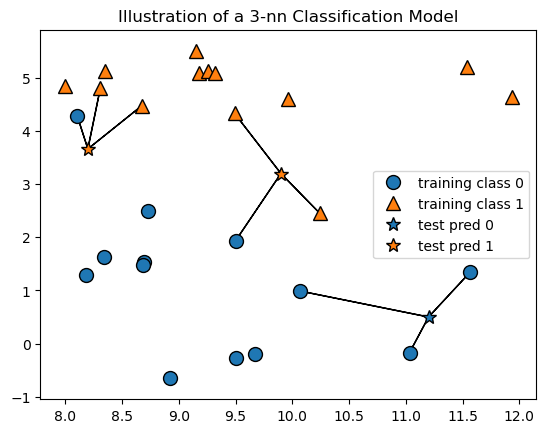

In [10]:
mglearn.plots.plot_knn_classification(n_neighbors=3)
plt.title('Illustration of a 3-nn Classification Model');

In K-nn models $k$ can be set to different values to control the behavior of the algorithm. $k$ represents the number of nearest neighbors to use in the prediction. Changing the value of $k$ can change the prediction, as we see below in the plot of a 1-nearest neighbor model. Notice that the new data point represented by the top left star is now classified as blue since its nearest neighbor is a blue circle.

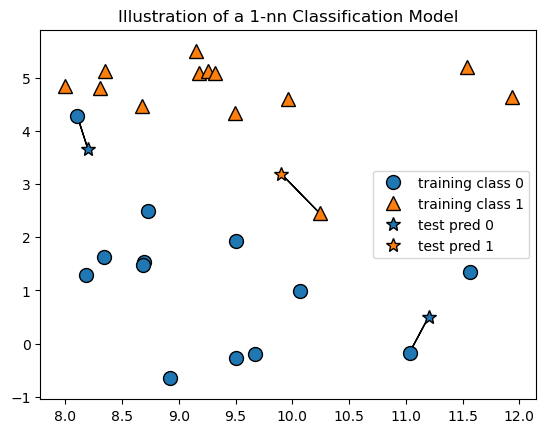

In [11]:
mglearn.plots.plot_knn_classification(n_neighbors=1)
plt.title('Illustration of a 1-nn Classification Model');

### Steps for Running One Iteration of a K-nn Classification Model in Scikit-Learn

Now we will demonstrate how to run one iteration of a 3-nn classification model using scikit-learn tools. Note that this is not an example of the full model building process. In a full model building process we would estimate generalization performance for multiple different algorithms, and then do a model tuning process to find the best parameter setting for the algorithm that had the best estimated generalization performance. Here we will simply split our data into training and test data, build a K-nn model with $k$ set to 3, train it on the training data, and then use it to make and score predictions on the test data. Although this is not the full model building process it illustrates a sequence of steps that happens multiple times inside a full model building process. It also will help us become more familiar with some of the tools provided by scikit-learn.

As we progress through the next few chapters we will add more sophisticated features to our model building and evaluation code. For example, here we do one train-test split. Later in the course we will test models over multiple train-test splits to estimate their generalization performance. Here we simply build a 3-nn model. Later we will learn how to perform a model tuning process to find the best setting for parameters such as $k$. Finally, here we calculate simple accuracy to evaluate our model. Simple accuracy is the default metric produced by the `score` method for K-nn classification. In a later chapter we will learn about some different performance measures for classification. 

Let's start by generating a dataset. We will use one of the utility functions from the mglearn package to do so. That data we generate will have two numeric features, and the target variable will be categorical, with the categories represented by the values 0 and 1.

#### Generate some data

In [12]:
# Generate a dataset to work with
X, y = mglearn.datasets.make_forge()

In [13]:
# Take a look at the shape of the features
X.shape

(26, 2)

In [14]:
# Look at the first 5 instances of the features
X[:5]

array([[ 9.96346605,  4.59676542],
       [11.0329545 , -0.16816717],
       [11.54155807,  5.21116083],
       [ 8.69289001,  1.54322016],
       [ 8.1062269 ,  4.28695977]])

In [15]:
# Take a look at the first 5 values of the target variable
y[:5]

array([1, 0, 1, 0, 0])

#### Split data into training and testing data

Before we build the model we will split our data into ***training data*** and ***testing data*** so that we can build the model with the training data and then test it on the test data. This allows us to estimate how well our model will ***generalize***, that is, how well it will perform on new data that was not part of the data on which it trained.  

We will use scikit-learn's `train_test_split()` function to do the splitting. By default, the `train_test_split()` function first randomly shuffles the data and then extracts 75% of the rows as training data. The remaining 25% of the rows are used as the test data.

**Note:** Here we have set `random_state = 0` in the `train_test_split` function. This is called a "random seed." This sets the pseudo-random-number generator's state, so that the results of the "random" split are repeatable. We will always get the same results from the "random" split if the `random_state` parameter is set to the same number.

The key arguments to the `train_test_split()` function are the features and the target variable. The function splits them and returns four datasets: the features for the training data, the features for the test data, the target variable values for the training data, and the target variable training values for the test data. We can use multiple assignment to assign those four datasets to four different variables, all in one line of code.

In [16]:
# Split the data into training data and test data using scikit-learn's train_test_split function
X_train, X_test, y_train, y_test = train_test_split(X, y, random_state=0)

In [17]:
# Take a look at the features in the training data
X_train

array([[ 8.92229526, -0.63993225],
       [ 8.7337095 ,  2.49162431],
       [ 9.32298256,  5.09840649],
       [ 7.99815287,  4.8525051 ],
       [11.0329545 , -0.16816717],
       [ 9.17748385,  5.09283177],
       [11.563957  ,  1.3389402 ],
       [ 9.15072323,  5.49832246],
       [ 8.34810316,  5.13415623],
       [11.93027136,  4.64866327],
       [ 8.1062269 ,  4.28695977],
       [ 8.67494727,  4.47573059],
       [ 9.67284681, -0.20283165],
       [ 9.50169345,  1.93824624],
       [ 8.69289001,  1.54322016],
       [ 9.96346605,  4.59676542],
       [ 9.50048972, -0.26430318],
       [ 9.25694192,  5.13284858],
       [ 8.68937095,  1.48709629]])

In [18]:
# Take a look at the target variable values in the training data
y_train

array([0, 0, 1, 1, 0, 1, 0, 1, 1, 1, 0, 1, 0, 0, 0, 1, 0, 1, 0])

#### Instantiate a min-max scaler and use it to transform the features 

Assign the scaled features in the training data to `X_train_scaled` and the scaled features in the test data to  `X_test_scaled`. **Important:** Scale both the training data and the test data according to the parameters of the training data. To do this we fit the scaler to the training data only, and then use the fitted scaler to transform both training and test data. This is an important principle of machine learning. Any feature transformations are always based only on the characteristics of the training data. This is because the test data simulates new data that we will apply the model to in the future. Thus, we would not have that data when we build the model and it cannot play a role in the model. The transformations are part of the model so they must be based on the training data only.

In [19]:
# Instantiate a min-max scaler
scaler = MinMaxScaler()

# Fit the scaler to the training data
scaler.fit(X_train)

# Use the scaler to transform the training features and the test features
X_train_scaled = scaler.transform(X_train)
X_test_scaled = scaler.transform(X_test)

#### Verify the results of the scaling transformation

We can verify that the max and mim of the features in the training data after scaling are 1 and 0, respectively. The max and min of the scaled features in the test data are in the same ballpark, but are not exactly 1 and 0 because the test data was scaled based on the characteristics of the training data.

In [20]:
print('Results of min-max scaling with MinMaxScaler:')
print(f'Train Scaled Max: {X_train_scaled.max(axis = 0)}')
print(f'Train Scaled Min: {X_train_scaled.min(axis = 0)}')
print(f'Test Scaled Max: {X_test_scaled.max(axis = 0)}')
print(f'Test Scaled Min: {X_test_scaled.min(axis = 0)}')

Results of min-max scaling with MinMaxScaler:
Train Scaled Max: [1. 1.]
Train Scaled Min: [0. 0.]
Test Scaled Max: [0.90114405 0.95321771]
Test Scaled Min: [0.04720805 0.26566392]


#### Instantiate a KNeighborsClassifier model, with k = 3

The algorithms that may be used within machine learning models are called ***estimators*** in scikit-learn. We instantiate an instance of an estimator by using its ***constructor function***. The constructor function for a K-nn model to be used for classification is `KNeighborsClassifier()`. Its main parameter is `n_neighbors`, which equates to $k$ in K-nn. It determines the number of nearest neighbors to be used to make the classification.

In [21]:
clf = KNeighborsClassifier(n_neighbors=3)

#### Fit the KNeighborsClassifier model to the scaled training data

Instances of estimators in scikit-learn all have a `fit()` method. This method is used to fit the model to the training data. In other words, the model uses the training data to learn how to make predictions for the target variable using the features.

In [22]:
clf.fit(X_train_scaled, y_train)

KNeighborsClassifier(n_neighbors=3)

#### We can make predictions using the KNeighborsClassifier object's `predict()` method

Once an estimator has been fit to the training data it will have a `predict()` method that can be used to make predictions and a `score()` method that can be used to make predictions, compare the predictions to the actual target variable values, and generate a score. For classification tasks the default scoring metric is accuracy.

In [23]:
# Take a look at the predictions for the scaled test data
clf.predict(X_test_scaled)

array([1, 0, 1, 0, 1, 0, 0])

In [24]:
# Take a look at the actual target variable values in the test data
y_test

array([1, 0, 1, 0, 1, 1, 0])

#### We can calculate an accuracy score for our predictions, using the KNeighborsClassifier object's `score` method.

In [25]:
# Take a look at the accuracy on the scaled training data
clf.score(X_train_scaled, y_train)

0.9473684210526315

In [26]:
# Take a look at the accuracy on the scaled test data
clf.score(X_test_scaled, y_test)

0.8571428571428571

We can see that our 3-nn model achieved 95% accuracy on the training data and 85% accuracy on the test data. 

Machine learning models will almost always perform better on the training data because that was the data on which they were trained. With K-nn models it makes sense that the model would perform better on the training data because for each row in the training data its nearest neighbor is itself! 

The only performance metric that matters is the model's performance on the test data. Because we held the test data back when training the model it is similar to future data to which we will apply the model. So, the model's performance on the test data is our best estimate of the model's generalization performance.

### Visualizing KNeighborsClassifier Decision Boundaries at Different Levels of $k$

The parameter $k$ that represents number of nearest neighbors to use to perform the classification is a parameter that controls the flexibility of the model to fit the training data. The lower the $k$ parameter the more flexible the model is to fit the training data. Higher levels of $k$ produce smoother decision boundaries because the model is less flexible. The code below creates graphs that show the model's decision boundary at different levels of $k$. 

The dots and triangles on the graphs represent the training data, which is one sample from a population. Our main concern isn't how well the model fits the displayed training data, but how well it will fit a new sample from the same population. Study the two plots below. One shows how a 1-nn model fits the data and another shows how a 7-nn model fits the data. The shaded regions show the decision boundary. Any new data that is in the orange region will be classified as an orange triangle and any new data that is in the blue region will be classified as a blue circle. Note how the 1-nn model is more flexible to fit the training data. That is, it adjusts perfectly to the training data and is 100% accurate on the training data because all the blue circles are in the blue region and all the orange triangles are in the orange region. The 7-nn model, in contrast, isn't as flexible to fit the training data; it doesn't adjust as much to fit the outliers. As a result it is NOT 100% accurate on the training data. Two points are misclassified.

It is possible, however, that the 1-nn model is overfitting the training data. Overfitting means fitting the training data so closely that the model picks up random variations in the training data that are not reflective of the population. This hurts the model's performance when it is applied to future data from the population. The 7-nn model, while it performs worse on the training data, may perform better on future data from the same population.

This is fake data, so we can't be sure, but this illustration should help you understand the fundamental concept of overfitting.

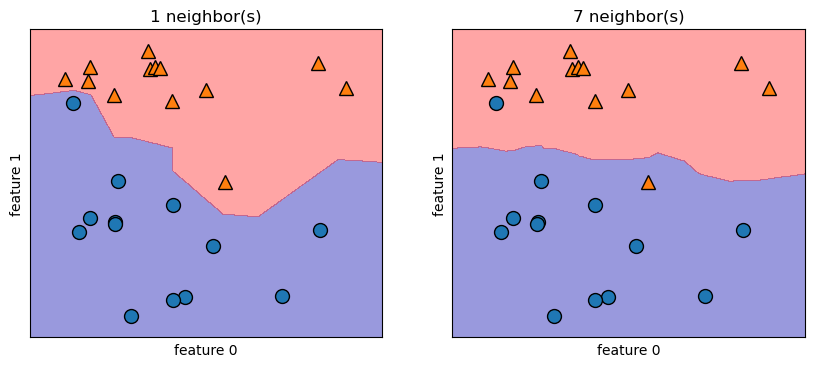

In [27]:
# Set levels of k here:
k1, k2 = 1, 7

fig, axes = plt.subplots(1, 2, figsize=(10, 4))

for n_neighbors, ax in zip([k1, k2], axes):
    # the fit method returns the object itself, so we can instantiate
    # and fit in one line
    clf = KNeighborsClassifier(n_neighbors=n_neighbors).fit(X, y)
    mglearn.plots.plot_2d_separator(clf, X, fill=True, eps=0.5, ax=ax, alpha=.4)
    mglearn.discrete_scatter(X[:, 0], X[:, 1], y, ax=ax)
    ax.set_title("{} neighbor(s)".format(n_neighbors))
    ax.set_xlabel("feature 0")
    ax.set_ylabel("feature 1");

## K-nn Models for Regression

K-nn can also be used for regression models. In machine learning regression models are models that predict a numeric quantity. To use K-nn for regression the target variable values of the $k$ neighbors are averaged to calculate the predicted target value for the new data point. 

The code below creates an illustrative plot. The x-axis represents the feature and the y-axis represents the target variable. The blue dots are the training data. Green stars are feature values for the test data, and the blue stars are the predictions for the test data. Note how the predictions are just the mean y values for the 3 nearest neighbors to the new instance.

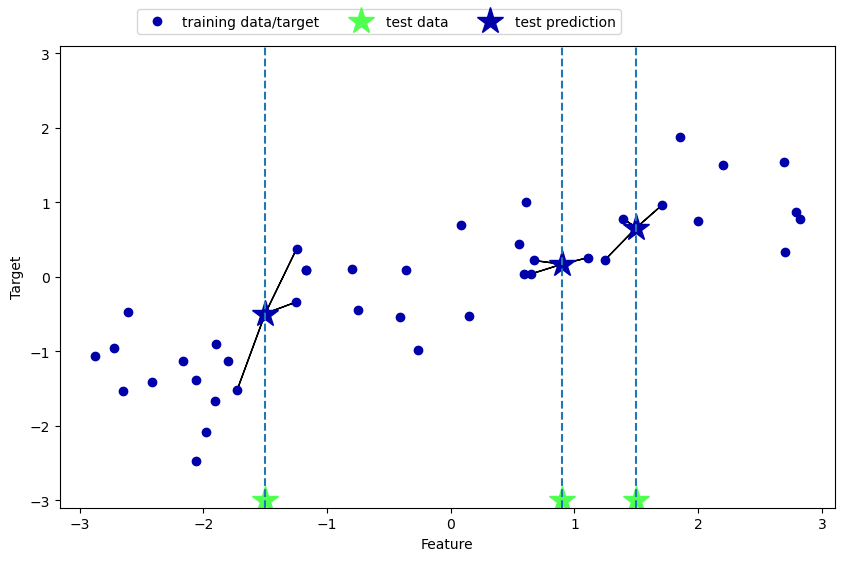

In [28]:
mglearn.plots.plot_knn_regression(n_neighbors=3)

### Running a K-nn Regression Model in Scikit-Learn

The basic steps to run a K-nn regression model using scikit-learn are similar to those for K-nn classification, but we use the `KNeighborsRegressor()` constructor function instead of `KNeighborsClassifier()` to build the estimator instance. Note also that the default performance metric produced by the `score` method for regression models is $R^2$ rather than accuracy.

### Visualizing KNeighborsRegressor Model Predictions at Different Levels of $k$

As with K-nn used for classification, the lower the $k$ parameter the more flexible the model is to fit the training data. In regression models this translates into a more jagged (flexible) decision function. Higher levels of $k$, by contrast, produce a smoother (less flexible) decision function. 

The plot below compares the decision function (the prediction line) for a 1-nn model with a 9-nn model. The blue triangles are the training data and the red triangles are the test data. Note that the prediction line for the 1-nn model is much more jagged, and it fits the training data perfectly. It doesn't fit the test model very well, however. The $R^2$ value for the test data is 0.35 with the 1-nn model. The 9-nn model has a smoother prediction line. It doesn't fit the training data as well but its performance on the test data is better, with an $R^2$ value of 0.65. We have evidence that the 1-nn model is overfitting the training data.

In [29]:
# Create dataset to use
X, y = mglearn.datasets.make_wave(n_samples=40)

# split the dataset into a training and a test set
X_train, X_test, y_train, y_test = train_test_split(X, y, random_state=0)

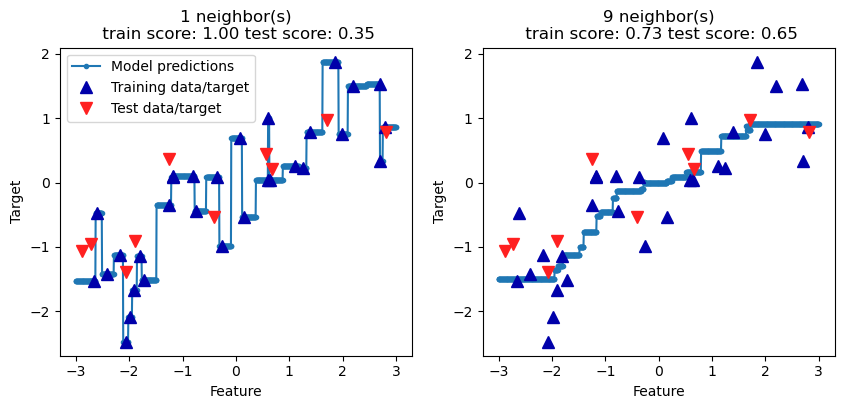

In [30]:
# Set values of k:
k1, k2 = 1, 9

fig, axes = plt.subplots(1, 2, figsize=(10, 4))
# create 1,000 data points, evenly spaced between -3 and 3
line = np.linspace(-3, 3, 1000).reshape(-1, 1)
for n_neighbors, ax in zip([k1, k2], axes):
    # make predictions using k1 or k2 neighbors
    reg = KNeighborsRegressor(n_neighbors=n_neighbors)
    reg.fit(X_train, y_train)
    ax.plot(line, reg.predict(line), linestyle='solid', marker='.') 
    ax.plot(X_train, y_train, '^', c=mglearn.cm2(0), markersize=8)
    ax.plot(X_test, y_test, 'v', c=mglearn.cm2(1), markersize=8)

    ax.set_title(
        "{} neighbor(s)\n train score: {:.2f} test score: {:.2f}".format(
            n_neighbors, reg.score(X_train, y_train),
            reg.score(X_test, y_test)))
    ax.set_xlabel("Feature")
    ax.set_ylabel("Target")
axes[0].legend(["Model predictions", "Training data/target",
                "Test data/target"], loc="best");

## K-nn Models Summary

Below is presented a summary of K-nn models, in bullet-point form. It highlights the important things that we should try to learn about each of the algorithms we use within supervised learning models. We should learn whether the algorithm is used for classification or regression or both, its important parameters, recommended preprocessing of the data before using the algorithm, and its general strengths and weaknesses.

**Uses:** Classification and Regression

**Important Parameters:**

- $k$ (number of neighbors)
- Method of distance calculation (uses Euclidean distance by default, but other distance calculations can be set with the `metric` parameter)

**Preprocessing:**

- Scaling required. Min-max scaling is typically applied
- Variable selection can help reduce noise in the model

**Strengths:**

- Easy to understand
- Often gives reasonable performance without a lot of adjustments
- Good baseline model to try before trying more advanced techniques
- Building the model is very fast

**Weaknesses:**

- If training set is very large the prediction can be slow
- Does not perform well on datasets with a very large number of features or on *sparse datasets* (datasets where most features are 0 most of the time)